In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
from copy import deepcopy
from matplotlib import cm
%matplotlib inline

In [2]:
sns.set(style='white', palette='Set2', font_scale=1.2)

def assign_colors(vals, cmap='Set2'):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    vals = sorted(list(set(vals)))
    nvals = len(vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

rawdata = sc.read('./data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('./data/annotations_FACS.csv', index_col=0) 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

full = sc.pp.recipe_seurat(rawdata, copy=True, log=False)

sc.pp.pca(full)
sc.pp.neighbors(full)

In [3]:
def get_downsampled_names(adata, N, group_key = 'cell_type'):
    '''Cluster-informed downsampling of cells in an anndata object
       adata: anndata object
       N: total N to downsample to
       group_key: where to find cluster IDs in adata.obs[]
       returns list of indices for selected observations
    '''
    assert 1 < N < len(adata.obs_names)
    assert group_key in adata.obs.columns.values, 'Oops. Choose another group key.'

    total_N = len(adata.obs_names)
    groups = adata.obs.groupby(group_key)
    all_selected = []

    for g, cells in groups.groups.items():
        group_size = len(cells)
        choose_k = int(N*(group_size/total_N))
        selected = random.sample(list(cells), k=choose_k)
        all_selected += selected
        
    return all_selected

def get_int_idx(adata, names):
    return np.where(adata.obs_names.isin(names))[0]

def get_shared_cellnames(adata1, adata2):
    return list(set(adata1.obs_names).intersection(set(adata2.obs_names)))

def get_igraph_from_adjacency(adjacency, metadata={}, directed=None):
    ''' from scanpy utils '''
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shap[0] vertices
    
    for field, vals in metadata.items():
        g.vs[field] = vals
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except:
        pass
    if g.vcount() != adjacency.shape[0]:
        logg.warn('The constructed graph has only {} nodes. '
                  'Your adjacency matrix contained redundant nodes.'
                  .format(g.vcount()))
    return g


def get_subgraph(full_graph, vertices):
    
    graph = deepcopy(full_graph)
    
    edges_to_remove = graph.es.select(lambda e: e.source not in vertices or e.target not in vertices)
    vertices_to_remove = graph.vs.select(lambda v: v.index not in vertices)
    
    graph.delete_edges(edges_to_remove)
    graph.delete_vertices(vertices_to_remove)
    
    return graph
    
def get_sparse_from_igraph(graph, weight_attr='weight'):
    ''' Also from scanpy utils '''
    from scipy.sparse import csr_matrix
    edges = graph.get_edgelist()
    if weight_attr is None:
        weights = [1] * len(edges)
    else:
        weights = graph.es[weight_attr]
    if not graph.is_directed():
        edges.extend([(v, u) for u, v in edges])
        weights.extend(weights)
    shape = graph.vcount()
    shape = (shape, shape)
    if len(edges) > 0:
        return csr_matrix((weights, zip(*edges)), shape=shape)
    else:
        return csr_matrix(shape)

def get_subset_adata(full_adata, selected_names):
    return deepcopy(full_adata)[selected_names, :]
    
def get_subset_adata_neighbors(full_adata, selected_names):
    
    idx_array = get_int_idx(full_adata, selected_names)
    
    full_ig = get_igraph_from_adjacency(full_adata.uns['neighbors']['connectivities'])
    subset_ig = get_subgraph(full_ig, idx_array)
    print(ig.summary(full_ig), ig.summary(subset_ig))
    subset_connectivities = get_sparse_from_igraph(subset_ig)
    print(full_adata.uns['neighbors']['distances'].toarray().shape)
    print(idx_array[:5], idx_array.shape)
    subset_distances = full_adata.uns['neighbors']['distances'].toarray()[np.ix_(idx_array,idx_array)]
    subset_adata = get_subset_adata(full_adata, selected_names)
    subset_adata.uns['neighbors'] = { 'params': full_adata.uns['neighbors']['params'],
                                      'connectivities': subset_connectivities,
                                      'distances': subset_distances}
    return subset_adata

In [10]:
small_names = get_downsampled_names(full, N=1000, group_key='cell_type') ## full dataset, evenly downsampled 1:5
small_clean = get_subset_adata(full, small_names)
small_subset = get_subset_adata_neighbors(full, small_names)

sc.pp.pca(small_clean)
sc.pp.pca(small_subset)
sc.pp.neighbors(small_clean)

bcell_names = full.obs.groupby('cell_type').groups['B cell'].tolist() ## just the b cells
bcell_names += full.obs.groupby('cell_type').groups['Fraction A pre-pro B cell'].tolist()
bcell_clean = get_subset_adata(full, bcell_names)
bcell_subset = get_subset_adata_neighbors(full, bcell_names)

sc.pp.pca(bcell_clean)
sc.pp.pca(bcell_subset)
sc.pp.neighbors(bcell_clean)

IGRAPH U-W- 5242 117066 -- 
+ attr: weight (e)
IGRAPH U-W- 930 3756 -- 
+ attr: weight (e)
None None
(5242, 5242)
[ 4  5 17 20 22] (930,)
IGRAPH U-W- 5242 117066 -- 
+ attr: weight (e)
IGRAPH U-W- 2025 47008 -- 
+ attr: weight (e)
None None
(5242, 5242)
[0 1 2 3 4] (2025,)


Text(0.5,1,'B cells: subset neighbor graph')

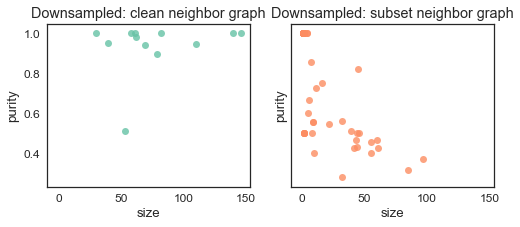

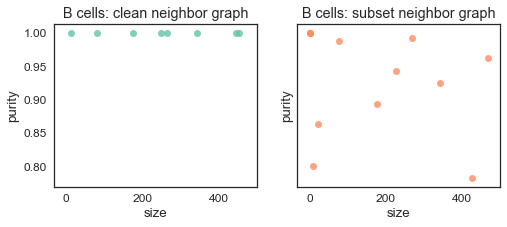

In [12]:
## Compare effects on clustering
sc.tl.louvain(full)
sc.tl.louvain(small_subset)
sc.tl.louvain(small_clean)
sc.tl.louvain(bcell_clean)
sc.tl.louvain(bcell_subset)

from collections import defaultdict

def calc_cluster_purity(adata, cluster_key, compare_key):
    
    clusters = adata.obs[cluster_key].values
    compare = adata.obs[compare_key].values
    
    cluster_groups = defaultdict(list)
    for cl, cp in zip(clusters, compare):
        cluster_groups[cl].append(cp)

    cluster_size =   { cl: len(cp) 
                      for cl, cp in cluster_groups.items()}
    cluster_groups = { cl: pd.value_counts(cp) 
                      for cl, cp in cluster_groups.items() }
    
    cluster_purity = { cl: cp[0]/cp.sum() 
                      for cl, cp in cluster_groups.items()}
    
    return pd.DataFrame({'size': cluster_size, 'purity': cluster_purity})
    
small_clean_cluster_purity = calc_cluster_purity(small_clean, 'louvain', 'cell_type')
small_subset_cluster_purity = calc_cluster_purity(small_subset, 'louvain', 'cell_type')

fig, axes = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=True, figsize=(8,3))
sns.regplot('size', 'purity', small_clean_cluster_purity, fit_reg=False, ax=axes[0])
axes[0].set_title('Downsampled: clean neighbor graph')

sns.regplot('size', 'purity', small_subset_cluster_purity, fit_reg=False, ax=axes[1])
axes[1].set_title('Downsampled: subset neighbor graph')


bcell_clean_cluster_purity = calc_cluster_purity(bcell_clean, 'louvain', 'cell_type')
bcell_subset_cluster_purity = calc_cluster_purity(bcell_subset, 'louvain', 'cell_type')

fig, axes = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=True, figsize=(8,3))
sns.regplot('size', 'purity', bcell_clean_cluster_purity, fit_reg=False, ax=axes[0])
axes[0].set_title('B cells: clean neighbor graph')

sns.regplot('size', 'purity', bcell_subset_cluster_purity, fit_reg=False, ax=axes[1])
axes[1].set_title('B cells: subset neighbor graph')



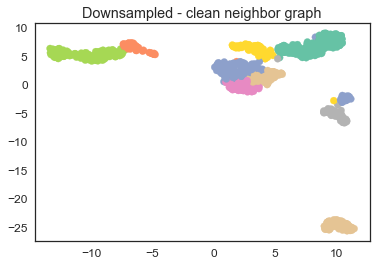

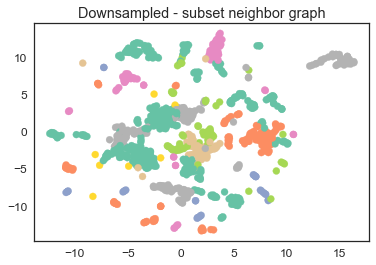

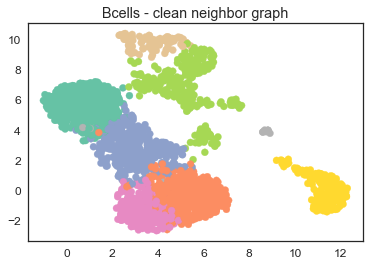

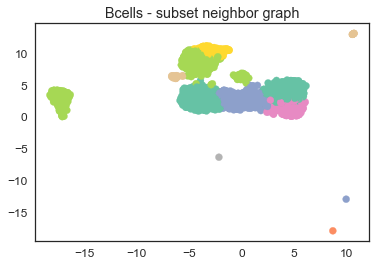

In [13]:
## Compare effects on umap layout
sc.tl.umap(small_clean)
sc.tl.umap(small_subset)
sc.tl.umap(bcell_clean)
sc.tl.umap(bcell_subset)

def plot_umap(adata, colorby = 'cell_type', title=None):
    fig, ax = plt.subplots()
    colors = assign_colors(pd.unique(adata.obs[colorby]))
    colors = [ colors[k] for k in adata.obs[colorby] ]
    plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=colors)
    
    if title:
        ax.set_title(title)

    plt.show()

plot_umap(small_clean, colorby='louvain', title='Downsampled - clean neighbor graph')
plot_umap(small_subset, colorby='louvain',title='Downsampled - subset neighbor graph')
plot_umap(bcell_clean, colorby='louvain', title='Bcells - clean neighbor graph')
plot_umap(bcell_subset, colorby='louvain', title='Bcells - subset neighbor graph')

/usr/local/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:830: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0/q, 0, W.shape[0], W.shape[0])
/usr/local/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:840: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0/z, 0, K.shape[0], K.shape[0])


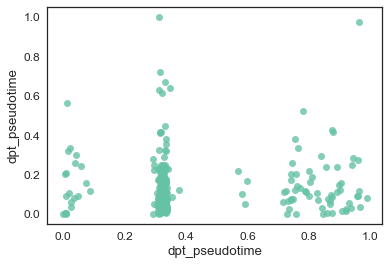

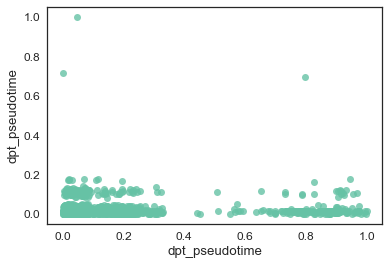

In [14]:
## Compare effects on dpt

def compare_pseudotime(adata1, adata2):
    
    shared_cells = get_shared_cellnames(adata1, adata2)
    random_start = random.choice(shared_cells)
    
    if 'dpt_pseudotime' not in adata1.obs:
        sc.tl.diffmap(adata1)
        adata1.var['xroot'] = adata1[random_start,:].X
        sc.tl.dpt(adata1)
        
    if 'dpt_pseudotime' not in adata2.obs:
        sc.tl.diffmap(adata2)
        adata2.var['xroot'] = adata2[random_start,:].X
        sc.tl.dpt(adata2)
     
    dpt1 = pd.Series(adata1.obs['dpt_pseudotime'], index=adata1.obs_names)
    dpt2 = pd.Series(adata2.obs['dpt_pseudotime'], index=adata2.obs_names)
        
    sns.regplot(dpt1[shared_cells], dpt2[shared_cells])
    plt.show()
    
compare_pseudotime(small_clean, small_subset)
compare_pseudotime(bcell_clean, bcell_subset)

In [5]:
# ## Compare effects on connections / underlying graph structure

# def connection_sensitivity_specificity(adata1, adata2):
    
#     shared = get_shared_cellnames(adata1, adata2)
#     idx1 = get_int_idx(adata1, shared)
#     idx2 = get_int_idx(adata2, shared)
    
#     adjacency1 = adata1.uns['neighbors']['connectivities'].toarray()[np.ix_(idx1, idx1)]
#     adjacency2 = adata2.uns['neighbors']['connectivities'].toarray()[np.ix_(idx2,idx2)]
#     dist1 = adata1.uns['neighbors']['distances'].toarray()[np.ix_(idx1, idx1)]
#     dist2 = adata2.uns['neighbors']['distances'].toarray()[np.ix_(idx2, idx2)]

#     mask = (dist1==0) & (dist2==0)
    
#     sns.regplot(dist1[~mask].flatten(), dist2[~mask].flatten())
#     plt.show()
    
#     tp = ((adjacency1 > 0) & (adjacency2 > 0)).sum().sum() ## true positive: both connected
#     tn = ((adjacency1 <= 0) & (adjacency2 <= 0)).sum().sum() ## true negative: both unconnected
#     fp = ((adjacency1 < 0) & (adjacency2 > 0)).sum().sum() ## false positive: 1 unconnected, 2 connected
#     fn = ((adjacency1 > 0) & (adjacency2 < 0)).sum().sum() ## false negative: 1 connected, 2 unconnected
    
#     stats = {'sensitivity': tp / (tp+fn), 'specificity': tn / (tn+fp)}
#     print(stats)
#     return stats

# connection_sensitivity_specificity(small_clean, full)